# Project Fletcher (NLP) -- Trends in Wikipedia Plot Summaries 
Topic Modeling on WikiPlots

### Dataset Description

The [WikiPlots corpus](https://github.com/markriedl/WikiPlots) is a collection of 112,936 story plots extracted from English language Wikipedia. These stories are extracted from any English language article that contains a sub-header that contains the word "plot" (e.g., "Plot", "Plot Summary", etc.).

_plots_: a text file containing all story plots. Each story plot is given with one sentence per line. Each story is followed by `<EOS>` on a line by itself.  
_titles_: a text file containing a list of titles for each article in which a story plot was found and extracted.

Code that generated text can be found [here](https://github.com/markriedl/WikiPlots/blob/master/wikiPlots.py).

### Imports and Globals

In [1]:
from pprint import pprint

import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
#nltk.download()
from gensim import corpora, models, similarities, matutils

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
%config Application.log_level="INFO"

# Get data

## Read in data

In [2]:
data_dir = "/home/ubuntu/raw_data"

In [3]:
### Read in Title texts
raw_titles = [line.strip().replace(".", "").replace("$", "_$")
              for line in open(data_dir+"/titles", encoding="utf8")]

print(raw_titles[0], raw_titles[1], raw_titles[2], "...")
print("Titles:" , len(raw_titles))
%store raw_titles

Animal Farm A Clockwork Orange (novel) The Plague ...
Titles: 112936
Stored 'raw_titles' (list)


In [4]:
### Read in Plot texts
import re
plot_boundary = re.compile("<EOS>\\n") # "<EOS>\n" separates plots

raw_plots = open(data_dir+"/plots", encoding="utf8").read()
raw_plots = re.split(plot_boundary, raw_plots)
del raw_plots[-1] #deletes the empty string at the end of resulting list
len(raw_plots)
%store raw_plots

Stored 'raw_plots' (list)


In [5]:
### Extract
pattern = 'Star Wars'
starwars_plots = []
for i, raw_plot in enumerate(raw_plots):
    if pattern in raw_titles[i]:
        starwars_plots.append((raw_titles[i], raw_plot))
len(starwars_plots)

90

In [6]:
### Extract
pattern = 'Star Trek'
startrek_plots = []
for i, raw_plot in enumerate(raw_plots):
    if pattern in raw_titles[i]:
        startrek_plots.append((raw_titles[i], raw_plot))
print(len(startrek_plots))
print(len(dict(startrek_plots)))

514
514


In [7]:
### Extract
pattern = 'Doctor Who'
who_plots = []
for i, raw_plot in enumerate(raw_plots):
    if pattern in raw_titles[i]: # or pattern in raw_plot:
        who_plots.append((raw_titles[i], raw_plot))
len(who_plots)

145

In [8]:
### Extract
pattern = 'zombies'
zomb_plots = []
for i, raw_plot in enumerate(raw_plots):
    if pattern in raw_titles[i]  or pattern in raw_plot:
        zomb_plots.append((raw_titles[i], raw_plot))
len(zomb_plots)

535

In [9]:
### Extract
pattern = 'zombies'
pattern_plots = []
for i, raw_plot in enumerate(raw_plots):
    if pattern in raw_titles[i]  or pattern in raw_plot:
        pattern_plots.append((raw_titles[i], raw_plot))
len(pattern_plots)

535

## Sub-sample the data and build data structures

In [10]:
sample_size = 10000

#sample_size=len(raw_plots)

### Randomly select subsample
# sampled_plots = random.sample(plot_dict.items(), sample_size)
# print("Number of selected plots: " + str(len(sampled_plots)))

### Select first items up to sample_size
if not sample_size:
    sample_size = len(raw_plots)

print("Sample size:", sample_size)

Sample size: 10000


In [11]:
plot_dict = dict(zip(raw_titles[:sample_size], raw_plots[:sample_size]))
print(plot_dict["Animal Farm"][:100])
print(len(plot_dict))

Old Major, the old boar on the Manor Farm, summons the animals on the farm together for a meeting, d
10000


In [12]:
# add star trek plots
plot_dict = {**plot_dict, **dict(startrek_plots)}
print(len(plot_dict))

# add
plot_dict = {**plot_dict, **dict(starwars_plots)}
print(len(plot_dict))

# add
plot_dict = {**plot_dict, **dict(who_plots)}
print(len(plot_dict))

#add zombies
plot_dict = {**plot_dict, **dict(zomb_plots)}
print(len(plot_dict))

10392
10466
10596
11088


## Dataframe

In [13]:
df = pd.DataFrame(plot_dict, index=['plot']).transpose().reset_index()
df.columns = ['title', 'plot']

patterns_scifi = ['Star Trek', 'Star Wars', 'Doctor Who', 'Asimov', 'Twilight Zone']

title_patterns = patterns_scifi
df['sci-fi'] = (df['title'].str.contains('|'.join(title_patterns)) | 
                df['plot'].str.contains('zombies'))

df.head()

,title,plot,sci-fi
0,That Thou Art Mindful of Him,"In this story, Asimov describesS.\nRobots' att...",False
1,&quot;A&quot; Is for Alibi,"""A"" Is for Alibi features Kinsey Millhone, 32,...",False
2,&quot;Master Harold&quot;and the Boys,"The play recounts the long, rainy afternoon th...",False
3,&quot;Pimpernel&quot; Smith,Eccentric Cambridge archaeologist Horatio Smit...,False
4,"&quot;Repent, Harlequin!&quot; Said the Tickto...",The story opens with a passage from Civil Diso...,False


In [14]:
df['sci-fi'].describe()

count     11088
unique        2
top       False
freq       9753
Name: sci-fi, dtype: object

In [15]:
from textblob import TextBlob

tb = TextBlob

df['polarity'] = df['plot'].apply(lambda x: tb(x).sentiment[0])
df['subjectivity'] = df['plot'].apply(lambda x: tb(x).sentiment[1])
df.head()

,title,plot,sci-fi,polarity,subjectivity
0,That Thou Art Mindful of Him,"In this story, Asimov describesS.\nRobots' att...",False,0.076348,0.400900
1,&quot;A&quot; Is for Alibi,"""A"" Is for Alibi features Kinsey Millhone, 32,...",False,-0.048737,0.300631
2,&quot;Master Harold&quot;and the Boys,"The play recounts the long, rainy afternoon th...",False,0.053964,0.427323
3,&quot;Pimpernel&quot; Smith,Eccentric Cambridge archaeologist Horatio Smit...,False,0.031731,0.423611
4,"&quot;Repent, Harlequin!&quot; Said the Tickto...",The story opens with a passage from Civil Diso...,False,0.010526,0.573183


In [16]:
#df.sort_values(['polarity'])

# Initial tests

## Pipeline structure (_unused_)

### Pipeline builder

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

def build(output_model, X, y=None):
    """
    Inner build function that builds a single model with NLTK Transformer
    """

    model = Pipeline([
        ('preprocessor', NLTKPreprocessor()),
        ('vectorizer', TfidfVectorizer(
            tokenizer=None, preprocessor=None, lowercase=False
        )),
        ('output_model', output_model),
    ])

    return model

In [18]:
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.cluster import KMeans, MiniBatchKMeans

models_dict = {
    
    "lsa" : TruncatedSVD(2, algorithm = 'randomized'),
    "nmf" : NMF(2),
    "km"  : MiniBatchKMeans()
    
}

In [19]:
# text_data = plot_dict.values()

#lsa_model = build(models_dict['lsa'], text_data)
#lsa_model.fit(text_data)
#lsa_model.explained_variance_ratio_

## Basic LSA example

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.preprocessing import Normalizer

In [21]:
#vectorizer = CountVectorizer(min_df = 5, max_df=1000, stop_words = 'english')
vectorizer = TfidfVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', token_pattern="\\b[a-z][a-z]+\\b")

In [22]:
count_mat = vectorizer.fit_transform(df['plot']) 

In [23]:
## Again, we do a fit_transform here.  This does two things:
## 1) It learns a mapping from a vector of words to a vector of "topics" or "reduced dimensions"
## 2) It applies that transformation to the count_mat and puts the result in reduced_mat

lsa = TruncatedSVD(50, algorithm = 'arpack')
reduced_mat = lsa.fit_transform(count_mat)

In [24]:
## This fit_transform is very simple.  It calculates the sum of squares for each row (the "fit" part) and 
## then divides each row by that amount (the "transform" part).  This just ensures that each vector has a "norm" of 1
## Vectors with a norm of 1 are easy to work with for calculating similarity.

reduced_mat = Normalizer(copy=False).fit_transform(reduced_mat)

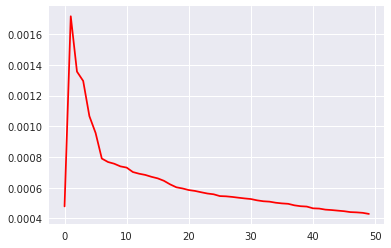

In [25]:
# This is (essentially) or eigenvalue plot (divided by the sum of eigenvalues).
plt.plot(lsa.explained_variance_ratio_,'r')

In [26]:
terms = np.array(vectorizer.get_feature_names())

In [27]:
## This is a simple convenience function which gets the highest valued terms for each topic

def get_topical_terms(topic_mat, topic_num, term_vec, num_terms=25):
    return term_vec[np.argsort(-topic_mat[topic_num,:])][:num_terms]

In [28]:
## Print the highest valued terms for each of the first 10 topics

for i in range(10):
    print("topic {}".format(i))
    print(get_topical_terms(lsa.components_,i,terms, 35))

topic 0
['doctor' 'time' 'new' 'man' 'father' 'ship' 'life' 'family' 'house'
 'tells' 'home' 'later' 'mother' 'world' 'story' 'finds' 'earth' 'crew'
 'love' 'death' 'war' 'jack' 'old' 'planet' 'group' 'takes' 'wife' 'years'
 'help' 'day' 'city' 'school' 'film' 'away' 'young']
topic 1
['kirk' 'enterprise' 'spock' 'ship' 'picard' 'crew' 'doctor' 'planet'
 'mccoy' 'data' 'captain' 'archer' 'federation' 'riker' 'voyager' 'earth'
 'starfleet' 'janeway' 'space' 'worf' 'klingon' 'commander' 'borg' 'alien'
 'romulan' 'vulcan' 'aboard' 'pol' 'orders' 'beam' 'kirk spock' 'tardis'
 'officer' 'warp' 'starship']
topic 2
['doctor' 'tardis' 'daleks' 'clara' 'voyager' 'earth' 'master' 'janeway'
 'rose' 'dalek' 'time' 'amy' 'cybermen' 'time lords' 'ace' 'seven' 'lords'
 'peri' 'chakotay' 'alien' 'brigadier' 'tuvok' 'ian' 'rory' 'human' 'lord'
 'episode' 'universe' 'gallifrey' 'donna' 'time lord' 'space' 'sarah'
 'torres' 'barbara']
topic 3
['homer' 'doctor' 'bart' 'lisa' 'marge' 'tardis' 'springfield' 

# Preprocessing

## Tokenize

### NLTK Transformer

Scikit-Learn Transformer class using NLTK modules
https://bbengfort.github.io/tutorials/2016/05/19/text-classification-nltk-sckit-learn.html

In [29]:
import string

from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag
from nltk import ne_chunk

from sklearn.base import BaseEstimator, TransformerMixin


class NLTKPreprocessor(BaseEstimator, TransformerMixin):

    def __init__(self, stopwords=None, punct=None,
                 lower=True, strip=True):
        self.lower      = lower
        self.strip      = strip
        self.stopwords  = stopwords or set(sw.words('english'))
        self.punct      = punct or set(string.punctuation)
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, X, y=None):
        return self

    def inverse_transform(self, X):
        return [" ".join(doc) for doc in X]

    def transform(self, X):
        return [
            list(self.tokenize(doc)) for doc in X
        ]

    def tokenize(self, document):
        # Break the document into sentences
        for sent in sent_tokenize(document):
            
            # Break the sentence into part of speech tagged tokens
            tagged_sent = pos_tag(wordpunct_tokenize(sent))
            
            # Get sentence tree with named entities
            #sent_tree = ne_chunk(tagged_sent)
            
            for token, tag in tagged_sent:
                
                # Apply preprocessing to the token
                token = token.lower() if self.lower else token
                token = token.strip() if self.strip else token
                token = token.strip('_') if self.strip else token
                token = token.strip('*') if self.strip else token

                # If stopword, ignore token and continue
                if token in self.stopwords:
                    continue

                # If punctuation, ignore token and continue
                if all(char in self.punct for char in token):
                    continue

                # Lemmatize the token and yield
                lemma = self.lemmatize(token, tag)
                yield lemma

    def lemmatize(self, token, tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)

### Get Tokens

In [30]:
import os.path
import pickle

text_data = df['plot']
nltk_preproc = NLTKPreprocessor()
sample_size = len(plot_dict)

# get tokens from file if we've done this before
file_path = 'tokens' + str(sample_size) + '.p'

if os.path.exists(file_path):
    with open(file_path, 'rb') as handle:
        all_tokens = pickle.load(handle)
        print("loaded tokens from file")
else:
    all_tokens = nltk_preproc.fit_transform(text_data)
    print("transformed new tokens")
    #save new tokens to file
    pickle.dump(all_tokens, open(file_path, "wb" ) )
    print("saved tokens to", str(file_path))

loaded tokens from file


In [31]:
joined_tokens = []
for token_group in all_tokens:
    token_group = ' '.join(token for token in token_group)
    joined_tokens.append(token_group)
joined_tokens[0][:100]
print(len(joined_tokens))

11088


In [32]:
df['token_list'] = all_tokens
df['tokens'] = joined_tokens
df.head(3)

,title,plot,sci-fi,polarity,subjectivity,token_list,tokens
0,That Thou Art Mindful of Him,"In this story, Asimov describesS.\nRobots' att...",False,0.076348,0.400900,"[story, asimov, describess, robot, attempt, in...",story asimov describess robot attempt introduc...
1,&quot;A&quot; Is for Alibi,"""A"" Is for Alibi features Kinsey Millhone, 32,...",False,-0.048737,0.300631,"[alibi, feature, kinsey, millhone, 32, private...",alibi feature kinsey millhone 32 private detec...
2,&quot;Master Harold&quot;and the Boys,"The play recounts the long, rainy afternoon th...",False,0.053964,0.427323,"[play, recount, long, rainy, afternoon, hally,...",play recount long rainy afternoon hally master...


## Vectorize

In [111]:
### COUNT
#vectorizer = CountVectorizer(min_df = 5, max_df=1000, stop_words = 'english')

### TFIDF
# vectorizer = TfidfVectorizer(ngram_range=(1, 2),  
#                                   stop_words='english', token_pattern="\\b[a-z][a-z]+\\b")

# use vectorizer below if text already preprocessed with NLTKPreprocessor()
vectorizer = TfidfVectorizer(ngram_range=(1, 1),
            tokenizer=None, preprocessor=None, lowercase=False, min_df=10)

### Document-Term Matrix
#dtm = vectorizer.fit_transform((map(str,df['plot'])))
dtm = vectorizer.fit_transform(joined_tokens)


print("(Documents, Terms)", dtm.shape)

(Documents, Terms) (11088, 15372)


# Modeling

## Gensim LDA

In [34]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(dtm)

# save a mapping (dict) of row id to word (token) for later use by gensim
id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())

In [35]:
# Create lda model (equivalent to "fit" in sklearn)
### Takes 8 min with 10k sample
# lda = models.LdaModel(corpus=corpus, num_topics=6, id2word=id2word, passes=10)

In [36]:
# lda.print_topics(num_words=20)

In [37]:
# Transform the docs from the word space to the topic space (like "transform" in sklearn)
# lda_corpus = lda[corpus]
# lda_corpus

In [38]:
# Store the documents' topic vectors in a list so we can take a peak
#lda_docs = [doc for doc in lda_corpus]

In [39]:
#lda_docs[0]

## Gensim LSI (LSA)

In [112]:
# Convert sparse matrix of counts to a gensim corpus
# Need to transpose it for gensim which wants 
# terms by docs instead of docs by terms
tfidf_corpus = matutils.Sparse2Corpus(dtm.transpose())

# Row indices
id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())

# This is a hack for Python 3!
id2word = corpora.Dictionary.from_corpus(tfidf_corpus, 
                                         id2word=id2word)

2017-08-25 09:46:44,595 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-08-25 09:46:46,575 : INFO : adding document #10000 to Dictionary(0 unique tokens: [])
2017-08-25 09:46:46,860 : INFO : built Dictionary(15372 unique tokens: ['story', 'asimov', 'robot', 'attempt', 'introduce']...) from 11088 documents (total 93004 corpus positions)


In [113]:
# Build an LSI space from the input TFIDF matrix, mapping of row id to word, and num_topics
# num_topics is the number of dimensions to reduce to after the SVD
# Analagous to "fit" in sklearn, it primes an LSI space
lsi = models.LsiModel(tfidf_corpus, id2word=id2word, num_topics=300)

2017-08-25 09:46:50,102 : INFO : using serial LSI version on this node
2017-08-25 09:46:50,103 : INFO : updating model with new documents
2017-08-25 09:46:50,615 : INFO : preparing a new chunk of documents
2017-08-25 09:46:51,167 : INFO : using 100 extra samples and 2 power iterations
2017-08-25 09:46:51,174 : INFO : 1st phase: constructing (15372, 400) action matrix
2017-08-25 09:46:52,122 : INFO : orthonormalizing (15372, 400) action matrix
2017-08-25 09:46:56,121 : INFO : 2nd phase: running dense svd on (400, 11088) matrix
2017-08-25 09:46:56,405 : INFO : computing the final decomposition
2017-08-25 09:46:56,409 : INFO : keeping 300 factors (discarding 11.954% of energy spectrum)
2017-08-25 09:46:56,476 : INFO : processed documents up to #11088
2017-08-25 09:46:56,485 : INFO : topic #0(16.221): 0.112*"find" + 0.107*"one" + 0.105*"take" + 0.101*"kill" + 0.089*"leave" + 0.089*"go" + 0.088*"time" + 0.083*"tell" + 0.082*"return" + 0.081*"life"
2017-08-25 09:46:56,489 : INFO : topic #1(7

In [114]:
# Retrieve vectors for the original tfidf corpus in the LSI space ("transform" in sklearn)
lsi_corpus = lsi[tfidf_corpus]

# Dump the resulting document vectors into a list so we can take a look
doc_vecs = [doc for doc in lsi_corpus]

In [115]:
# Create an index transformer that calculates similarity based on 
# our space
index = similarities.MatrixSimilarity(doc_vecs, 
                                      num_features=len(id2word))

# Return the sorted list of cosine similarities to the first document
sims = sorted(enumerate(index[doc_vecs[0]]), key=lambda item: -item[1])
#sims

2017-08-25 09:47:15,413 : INFO : creating matrix with 11088 documents and 15372 features


In [142]:
def get_sim_doc(doc):
    vec_bow = id2word.doc2bow(doc.lower().split())
    vec_lsi = lsi[vec_bow] # convert the query to LSI space
    #print(vec_lsi)

    sims = index[vec_lsi] # perform a similarity query against the corpus

    sims = sorted(enumerate(sims), key=lambda item: -item[1])
    print(sims[0]) # print sorted (document number, similarity score) 2-tuples
    most_sim_doc = sims[0][0]

    return df.iloc[most_sim_doc]

doc = "run jump escape free climb flee"
doc = "laugh joy marry romance fun smile"
doc = "die death kill stab shoot murder"
doc = "dragon king queen war wall north"
#doc = "explore reveal uncover"

get_sim_doc(doc)

(106, 0.62725115)


title                                            A Clash of Kings
index                                                         106
plot            A Clash of Kings depicts the Seven Kingdoms of...
sci-fi                                                      Other
polarity                                                0.0639105
subjectivity                                               0.4589
token_list      [clash, king, depict, seven, kingdom, westeros...
tokens          clash king depict seven kingdom westeros civil...
neg                                                  Non-negative
killing                                                  has_kill
subj                                              Less Subjective
Name: 106, dtype: object

## Truncated SVD (LSA)

In [117]:
# Fit LSA. Use algorithm = “randomized” for large datasets 
lsa = TruncatedSVD(2, algorithm = 'arpack')
dtm_lsa = lsa.fit_transform(dtm)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)

In [118]:
lsa.explained_variance_ratio_

array([ 0.00227908,  0.00540628])

In [119]:
pd.DataFrame(lsa.components_.round(5),index = ["component_1","component_2"],
             columns = vectorizer.get_feature_names())

,00,000,007,10,100,1000,104,105,10th,11,...,zoe,zombie,zombies,zombification,zombified,zone,zoo,zoom,émigré,état
component_1,0.00154,0.01430,0.00102,0.00892,0.00516,0.00133,0.00042,0.00052,0.00096,0.00498,...,0.00432,0.05483,0.00097,0.00038,0.00243,0.00880,0.00328,0.00051,0.00044,0.00097
component_2,-0.00015,-0.00143,0.00087,-0.00225,-0.00094,-0.00002,0.00054,-0.00020,0.00000,-0.00049,...,0.00311,-0.01119,0.00013,0.00029,0.00001,0.01782,-0.00017,-0.00019,-0.00043,0.00072


In [120]:
df.reset_index(inplace=True)

In [121]:
pd.DataFrame(dtm_lsa.round(5), index = df['title'], columns = ["component_1","component_2" ])

,component_1,component_2
title,,
That Thou Art Mindful of Him,0.89707,0.44188
&quot;A&quot; Is for Alibi,0.96993,-0.24340
&quot;Master Harold&quot;and the Boys,0.93088,-0.36534
&quot;Pimpernel&quot; Smith,0.99595,-0.08990
"&quot;Repent, Harlequin!&quot; Said the Ticktockman",0.99260,-0.12140
&quot;—And He Built a Crooked House—&quot;,0.99793,-0.06427
'Allo 'Allo!,0.99798,-0.06360
'Salem's Lot,0.95823,-0.28601
'Scuse Me While I Miss the Sky,0.94024,-0.34051


In [122]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(dtm_lsa) * np.asmatrix(dtm_lsa).T) 

In [123]:
pd.DataFrame(similarity.round(6), index=plot_dict.keys(), columns=plot_dict.keys())

,Animal Farm,A Clockwork Orange (novel),The Plague,Actaeon,A Fire Upon the Deep,All Quiet on the Western Front,Anyone Can Whistle,A Funny Thing Happened on the Way to the Forum,Army of Darkness,The Birth of a Nation,...,Dead Rising 4,Under One Person,The Rezort,"My Dear Girl, Jin-young",The Waking Dead,"Goodnight, Sweet Grimm",The Ungrateful Dead,Bloody New Year,Night Club (2011 film),Avengers 1959
Animal Farm,1.000000,0.762543,0.673628,0.853716,0.836794,0.866816,0.867153,0.733220,0.692999,0.989790,...,0.944800,0.954307,0.993931,0.907749,0.666556,0.708606,0.654319,0.642018,0.896657,0.982135
A Clockwork Orange (novel),0.762543,1.000000,0.991803,0.987881,0.992301,0.983566,0.983443,0.999024,0.994844,0.846967,...,0.932418,0.921023,0.829083,0.963597,0.990540,0.996824,0.988173,0.985567,0.970155,0.870661
The Plague,0.673628,0.991803,1.000000,0.959950,0.968342,0.952433,0.952226,0.996479,0.999648,0.772092,...,0.878598,0.863703,0.750843,0.921535,0.999955,0.998828,0.999667,0.999119,0.931219,0.800672
Actaeon,0.853716,0.987881,0.959950,1.000000,0.999498,0.999670,0.999652,0.980060,0.967045,0.919222,...,0.977210,0.970318,0.905820,0.993417,0.957237,0.972384,0.952395,0.947346,0.996035,0.936456
A Fire Upon the Deep,0.836794,0.992301,0.968342,0.999498,1.000000,0.998354,0.998315,0.985862,0.974624,0.906290,...,0.969996,0.962172,0.891947,0.989290,0.965920,0.979288,0.961573,0.957013,0.992717,0.924876
All Quiet on the Western Front,0.866816,0.983566,0.952433,0.999670,0.998354,1.000000,1.000000,0.974630,0.960183,0.929037,...,0.982342,0.976213,0.916409,0.996033,0.949486,0.966065,0.944246,0.938804,0.997992,0.945162
Anyone Can Whistle,0.867153,0.983443,0.952226,0.999652,0.998315,1.000000,1.000000,0.974478,0.959993,0.929287,...,0.982468,0.976359,0.916679,0.996093,0.949274,0.965890,0.944023,0.938571,0.998035,0.945383
A Funny Thing Happened on the Way to the Forum,0.733220,0.999024,0.996479,0.980060,0.985862,0.974630,0.974478,1.000000,0.998353,0.822655,...,0.915544,0.902917,0.803574,0.950846,0.995635,0.999369,0.993982,0.992083,0.958496,0.848081
Army of Darkness,0.692999,0.994844,0.999648,0.967045,0.974624,0.960183,0.959993,0.998353,1.000000,0.788681,...,0.890959,0.876770,0.768102,0.931513,0.999350,0.999761,0.998630,0.997654,0.940560,0.816284
The Birth of a Nation,0.989790,0.846967,0.772092,0.919222,0.906290,0.929037,0.929287,0.822655,0.788681,1.000000,...,0.981854,0.987156,0.999463,0.958275,0.766003,0.801943,0.755425,0.744741,0.950605,0.998929


In [139]:
dtm.shape

(11088, 15372)

## NMF

In [52]:
from sklearn.decomposition import NMF

nmf_model = NMF(2)

dtm_nmf = nmf_model.fit_transform(dtm)
dtm_nmf = Normalizer(copy=False).fit_transform(dtm_nmf)

In [53]:
nmf_model.components_

array([[  4.97704483e-03,   5.01865501e-02,   8.69151490e-04, ...,
          6.14202503e-05,   6.14202503e-05,   1.53950206e-04],
       [  2.29171782e-03,   1.33766415e-02,   4.49336950e-05, ...,
          2.75561207e-05,   2.75561207e-05,   0.00000000e+00]])

## Word2Vec

In [54]:
from gensim import models
# text = ['testin','testing','testing']
# model = models.Word2Vec(text,workers=4)

2017-08-25 07:42:11,384 : INFO : collecting all words and their counts
2017-08-25 07:42:11,387 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings).First item here is instead plain <class 'str'>.
2017-08-25 07:42:11,389 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-08-25 07:42:11,392 : INFO : collected 6 word types from a corpus of 20 raw words and 3 sentences
2017-08-25 07:42:11,394 : INFO : Loading a fresh vocabulary
2017-08-25 07:42:11,396 : INFO : min_count=5 retains 1 unique words (16% of original 6, drops 5)
2017-08-25 07:42:11,396 : INFO : min_count=5 leaves 6 word corpus (30% of original 20, drops 14)
2017-08-25 07:42:11,397 : INFO : deleting the raw counts dictionary of 6 items
2017-08-25 07:42:11,401 : INFO : sample=0.001 downsamples 1 most-common words
2017-08-25 07:42:11,402 : INFO : downsampling leaves estimated 0 word corpus (3.3% of prior 6)
2017-08-25 07:42:11,402 : INFO : estimated required memory for 1

In [55]:
w2v = models.Word2Vec(all_tokens, size=100, window=5, min_count=1, workers=4,sg=1)

2017-08-25 07:42:11,431 : INFO : collecting all words and their counts
2017-08-25 07:42:11,432 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-08-25 07:42:12,301 : INFO : PROGRESS: at sentence #10000, processed 3101984 words, keeping 86719 word types
2017-08-25 07:42:12,401 : INFO : collected 91848 word types from a corpus of 3435195 raw words and 11088 sentences
2017-08-25 07:42:12,402 : INFO : Loading a fresh vocabulary
2017-08-25 07:42:12,883 : INFO : min_count=1 retains 91848 unique words (100% of original 91848, drops 0)
2017-08-25 07:42:12,884 : INFO : min_count=1 leaves 3435195 word corpus (100% of original 3435195, drops 0)
2017-08-25 07:42:13,183 : INFO : deleting the raw counts dictionary of 91848 items
2017-08-25 07:42:13,186 : INFO : sample=0.001 downsamples 13 most-common words
2017-08-25 07:42:13,187 : INFO : downsampling leaves estimated 3407150 word corpus (99.2% of prior 3435195)
2017-08-25 07:42:13,188 : INFO : estimated required memory

2017-08-25 07:43:27,316 : INFO : PROGRESS: at 78.36% examples, 184213 words/s, in_qsize 7, out_qsize 0
2017-08-25 07:43:28,354 : INFO : PROGRESS: at 79.48% examples, 184259 words/s, in_qsize 7, out_qsize 0
2017-08-25 07:43:29,407 : INFO : PROGRESS: at 80.67% examples, 184276 words/s, in_qsize 7, out_qsize 0
2017-08-25 07:43:30,449 : INFO : PROGRESS: at 81.77% examples, 184305 words/s, in_qsize 7, out_qsize 0
2017-08-25 07:43:31,497 : INFO : PROGRESS: at 82.91% examples, 184314 words/s, in_qsize 7, out_qsize 0
2017-08-25 07:43:32,531 : INFO : PROGRESS: at 84.07% examples, 184365 words/s, in_qsize 7, out_qsize 0
2017-08-25 07:43:33,552 : INFO : PROGRESS: at 85.20% examples, 184440 words/s, in_qsize 7, out_qsize 0
2017-08-25 07:43:34,587 : INFO : PROGRESS: at 86.30% examples, 184463 words/s, in_qsize 7, out_qsize 0
2017-08-25 07:43:35,611 : INFO : PROGRESS: at 87.47% examples, 184520 words/s, in_qsize 7, out_qsize 0
2017-08-25 07:43:36,627 : INFO : PROGRESS: at 88.69% examples, 184589 wor

In [56]:
w2v.most_similar(positive=['worker', 'woman'], negative=['free'], topn=5)

2017-08-25 07:43:46,773 : INFO : precomputing L2-norms of word weight vectors


[('prostitute', 0.5769666433334351),
 ('waitress', 0.5273051857948303),
 ('customer', 0.525159478187561),
 ('tenant', 0.5204402208328247),
 ('attractive', 0.5159347057342529)]

In [57]:
print(w2v.similarity('woman','man'))

0.717781360955


In [58]:
# Finding words that don't match others in a bag
print(w2v.doesnt_match("comedy tragedy adventure lunch".split()))

lunch


### Load Google's Word2Vec

In [59]:
#w2v = models.KeyedVectors.load_word2vec_format(data_dir+"/GoogleNews-vectors-negative300.bin",binary=True)

In [60]:
#print(w2v.similarity('woman','man'))

In [61]:
#w2v.most_similar(positive=['woman', 'king'], negative=['man'], topn=3)

### Cluster Word Vectors

In [62]:
from sklearn.cluster import KMeans 
from numbers import Number
import sys, codecs

In [63]:
class autovivify_list(dict):
    '''A pickleable version of collections.defaultdict'''
    def __missing__(self, key):
        '''Given a missing key, set initial value to an empty list'''
        value = self[key] = []
        return value

    def __add__(self, x):
        '''Override addition for numeric types when self is empty'''
        if not self and isinstance(x, Number):
            return x
        raise ValueError

    def __sub__(self, x):
        '''Also provide subtraction method'''
        if not self and isinstance(x, Number):
            return -1 * x
        raise ValueError

In [64]:
def build_word_vector_matrix(vector_file, n_words):
    '''Return the vectors and labels for the first n_words in vector file'''
    numpy_arrays = []
    labels_array = []
    with codecs.open(vector_file, 'r', 'utf-8') as f:
        for c, r in enumerate(f):
            sr = r.split()
            labels_array.append(sr[0])
            numpy_arrays.append( numpy.array([float(i) for i in sr[1:]]) )

            if c == n_words:
                return numpy.array( numpy_arrays ), labels_array

        return numpy.array( numpy_arrays ), labels_array

In [65]:
def find_word_clusters(labels_array, cluster_labels):
    '''Return the set of words in each cluster'''
    cluster_to_words = autovivify_list()
    for c, i in enumerate(cluster_labels):
        cluster_to_words[ i ].append( labels_array[c] )
    return cluster_to_words

## Summarization

In [66]:
df = df.set_index('title')
df.head(5)

,index,plot,sci-fi,polarity,subjectivity,token_list,tokens
title,,,,,,,
That Thou Art Mindful of Him,0,"In this story, Asimov describesS.\nRobots' att...",False,0.076348,0.400900,"[story, asimov, describess, robot, attempt, in...",story asimov describess robot attempt introduc...
&quot;A&quot; Is for Alibi,1,"""A"" Is for Alibi features Kinsey Millhone, 32,...",False,-0.048737,0.300631,"[alibi, feature, kinsey, millhone, 32, private...",alibi feature kinsey millhone 32 private detec...
&quot;Master Harold&quot;and the Boys,2,"The play recounts the long, rainy afternoon th...",False,0.053964,0.427323,"[play, recount, long, rainy, afternoon, hally,...",play recount long rainy afternoon hally master...
&quot;Pimpernel&quot; Smith,3,Eccentric Cambridge archaeologist Horatio Smit...,False,0.031731,0.423611,"[eccentric, cambridge, archaeologist, horatio,...",eccentric cambridge archaeologist horatio smit...
"&quot;Repent, Harlequin!&quot; Said the Ticktockman",4,The story opens with a passage from Civil Diso...,False,0.010526,0.573183,"[story, open, passage, civil, disobedience, he...",story open passage civil disobedience henry da...


In [67]:
from gensim.summarization import summarize

In [68]:
plot_to_summarize = 'Animal Farm'
plot_to_summarize = df.loc[plot_to_summarize]['plot']
title = ""
print(title) 
print(summarize(plot_to_summarize, ratio=0.2))

2017-08-25 07:43:46,960 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-08-25 07:43:46,963 : INFO : built Dictionary(255 unique tokens: ['old', 'major', 'boar', 'manor', 'farm']...) from 38 documents (total 425 corpus positions)



Old Major, the old boar on the Manor Farm, summons the animals on the farm together for a meeting, during which he refers to humans as "enemies" and teaches the animals a revolutionary song called "Beasts of England".
When Major dies, two young pigs, Snowball and Napoleon, assume command and consider it a duty to prepare for the Rebellion.
Jones and his men are making an attempt to recapture the farm, aided by several other farmers who are terrified of similar animal revolts.
When the animals find the windmill collapsed after a violent storm, Napoleon and Squealer convince the animals that Snowball is trying to sabotage their project.
Once Snowball becomes a scapegoat, Napoleon begins to purge the farm with his dogs, killing animals he accuses of consorting with his old rival.
In a subsequent report, Squealer reports sadly to the animals that Boxer died peacefully at the animal hospital; the pigs hold a festival one day after Boxer's death to further praise the glories of Animal Farm 

In [69]:
from gensim.summarization import keywords

plot_to_summarize = 'Animal Farm'
plot_to_summarize = df.loc[plot_to_summarize]['plot']

print('Keywords:')
print(keywords(plot_to_summarize))

Keywords:
napoleon
animals
animal
animalism
snowball
farm
farms
pigs
pig
squealer
farmer
farmers
windmill
boxer
old
runs
run
running
report
reports
lighting
surgeon
lives
live
dies
died
food
including
attack
attacks
work
working
young
upright carry
revolutionary song called
command
commandments
years
aside special
items
replacing
replaced
beasts
major
storm


In [70]:
# df['keywords'] = df['tokens'].apply(lambda x: keywords(x))
# df.head()

# Recommender Systems

In [71]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import euclidean_distances

In [72]:
# from sklearn.utils.extmath import randomized_svd

# U, Sigma, VT = randomized_svd(dtm, 
#                               n_components=15,
#                               n_iter=5,
#                               random_state=None)

In [74]:
# ITEMID1 = 1    # Toy Story (1995)
# ITEMID2 = 2355 # A bug's life (1998)
# print(svd.similarity(ITEMID1, ITEMID2))

# Visualization

In [75]:
import scattertext as st
import spacy

In [132]:
#create category columns

df['killing'] = df['tokens'].str.contains('kill')
df['killing'] = df['killing'].apply(lambda x: "has_kill" if x==True else "no_kill")
#df['killing'].describe()

df['sci-fi'] = df['sci-fi'].apply(lambda x: "Sci-Fi" if x==True else "Other")

df['neg'] = df['polarity'] < (df['polarity'].describe()[4]) #below 25 percentile
df['neg'] = df['neg'].apply(lambda x: "Negative" if x==True else "Non-negative")

df['subj'] = df['subjectivity'] < (df['subjectivity'].describe()[4]) #below 25 percentile
df['subj'] = df['subj'].apply(lambda x: "More Subjective" if x==True else "Less Subjective")
#df['neg'].describe()

In [125]:
nlp = spacy.en.English()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11088 entries, 0 to 11087
Data columns (total 10 columns):
title           11088 non-null object
index           11088 non-null int64
plot            11088 non-null object
sci-fi          11088 non-null object
polarity        11088 non-null float64
subjectivity    11088 non-null float64
token_list      11088 non-null object
tokens          11088 non-null object
neg             11088 non-null object
killing         11088 non-null object
dtypes: float64(2), int64(1), object(7)
memory usage: 866.3+ KB


In [133]:
corpus = st.CorpusFromPandas(df, 
                              category_col='subj', 
                              text_col='plot',
                              nlp=nlp).build()

In [134]:
print(list(corpus.get_scaled_f_scores_vs_background().index[:10]))

['discovers', 'tells', 'decides', 'learns', 'arrives', 'realizes', 'tries', 'finds', 'refuses', 'reveals']


In [128]:
corpus.get_scaled_f_scores_vs_background()

,corpus,background,Scaled f-score
reveal,5754.0,8278392.0,0.000986
kill,12609.0,24850951.0,0.000893
marry,3203.0,4388137.0,0.000824
arrive,5676.0,11812688.0,0.000747
zombie,2627.0,4406565.0,0.000674
destroy,4443.0,9811516.0,0.000673
flee,1703.0,1724638.0,0.000666
escape,6232.0,15631531.0,0.000655
confront,1717.0,2056392.0,0.000631
convince,2110.0,3962104.0,0.000574


In [135]:
term_freq_df = corpus.get_term_freq_df()

In [136]:
term_freq_df['Subj Score'] = corpus.get_scaled_f_scores('More Subjective')
pprint(list(term_freq_df.sort_values(by='Subj Score', 
                                      ascending=False).index[:10]))

['the shark',
 'mort',
 'itsuki',
 'piro',
 'cao',
 'jubei',
 'andré',
 'herod',
 'magua',
 'hornblower']


In [137]:
html = st.produce_scattertext_explorer(corpus,
...          category='More Subjective',
...          category_name='More Subjective',
...          not_category_name="Less Subjective",
...          width_in_pixels=1000
...          )
#metadata=df['title']

open("visualization.html", 'wb').write(html.encode('utf-8'))

47345582

# More DF Tranforms

In [ ]:
df.reset_index(inplace=True)
df.head()

In [ ]:
df['LotR'] = df['title'].str.contains('Lord of the Rings')
df['LotR'].describe()

In [ ]:
df['GoT'] = df['title'].str.contains('Game of Thrones')
df['GoT'].describe()

In [90]:
df['killing'] = df['tokens'].str.contains('kill')
df['killing'].describe()

count     11088
unique        2
top       False
freq       6069
Name: killing, dtype: object

In [108]:
df.head()

,index,plot,sci-fi,polarity,subjectivity,token_list,tokens,neg,killing
title,,,,,,,,,
That Thou Art Mindful of Him,0,"In this story, Asimov describesS.\nRobots' att...",Other,0.076348,0.400900,"[story, asimov, describess, robot, attempt, in...",story asimov describess robot attempt introduc...,Non-negative,no_kill
&quot;A&quot; Is for Alibi,1,"""A"" Is for Alibi features Kinsey Millhone, 32,...",Other,-0.048737,0.300631,"[alibi, feature, kinsey, millhone, 32, private...",alibi feature kinsey millhone 32 private detec...,Negative,has_kill
&quot;Master Harold&quot;and the Boys,2,"The play recounts the long, rainy afternoon th...",Other,0.053964,0.427323,"[play, recount, long, rainy, afternoon, hally,...",play recount long rainy afternoon hally master...,Non-negative,has_kill
&quot;Pimpernel&quot; Smith,3,Eccentric Cambridge archaeologist Horatio Smit...,Other,0.031731,0.423611,"[eccentric, cambridge, archaeologist, horatio,...",eccentric cambridge archaeologist horatio smit...,Non-negative,no_kill
"&quot;Repent, Harlequin!&quot; Said the Ticktockman",4,The story opens with a passage from Civil Diso...,Other,0.010526,0.573183,"[story, open, passage, civil, disobedience, he...",story open passage civil disobedience henry da...,Non-negative,no_kill


In [109]:
df.sort_values(['polarity'])

,index,plot,sci-fi,polarity,subjectivity,token_list,tokens,neg,killing
title,,,,,,,,,
Conker's Pocket Tales,1819,"Conker celebrates his birthday, but the Evil A...",Other,-1.000000,1.000000,"[conker, celebrate, birthday, evil, acorn, ste...",conker celebrate birthday evil acorn steal pre...,Negative,no_kill
Aero the Acro-Bat,340,Aero the Acro-Bat works and lives in The World...,Other,-1.000000,1.000000,"[aero, acro, bat, work, life, world, amusement...",aero acro bat work life world amusement circus...,Negative,no_kill
Hamlet (1990 film),3425,"In Denmark, Prince Hamlet finds himself involv...",Other,-1.000000,1.000000,"[denmark, prince, hamlet, find, involve, consp...",denmark prince hamlet find involve conspiracy ...,Negative,has_kill
Faith of Our Fathers (short story),2787,Tung Chien is a Vietnamese bureaucrat in a wor...,Other,-0.633333,0.733333,"[tung, chien, vietnamese, bureaucrat, world, c...",tung chien vietnamese bureaucrat world conquer...,Negative,no_kill
Mach Rider,4715,"Mach Rider takes place in the year 2112, and p...",Other,-0.600000,0.500000,"[mach, rider, take, place, year, 2112, planet,...",mach rider take place year 2112 planet earth i...,Negative,no_kill
The Glorious Revolution (Doctor Who audio),8506,"Time goes wrong for the Doctor in 1688, when K...",Other,-0.500000,0.900000,"[time, go, wrong, doctor, 1688, king, james, i...",time go wrong doctor 1688 king james ii fight ...,Negative,no_kill
Black Magic 2,1095,A martial artist fights against an evil sorcer...,Other,-0.500000,0.500000,"[martial, artist, fight, evil, sorcerer, raise...",martial artist fight evil sorcerer raise zombie,Negative,no_kill
Apocalypse Zero,651,Kakugo and Harara are siblings trained to figh...,Other,-0.500000,0.500000,"[kakugo, harara, sibling, train, fight, monste...",kakugo harara sibling train fight monster roam...,Negative,no_kill
Bulldog Drummond's Secret Police,1381,An absent-minded Professor Downie (Forrester H...,Other,-0.500000,1.000000,"[absent, mind, professor, downie, forrester, h...",absent mind professor downie forrester harvey ...,Negative,no_kill


# **Wherein We Do It Live**

In [195]:
# Gensim LSI similiatiry
def get_sim_docs(doc):
    vec_bow = id2word.doc2bow(doc.lower().split())
    vec_lsi = lsi[vec_bow] # convert the query to LSI space

    sims = index[vec_lsi] # perform a similarity query against the corpus

    sims = sorted(enumerate(sims), key=lambda item: -item[1])
    most_sim_docs = [sims[0][0], sims[1][0], sims[2][0], sims[3][0], sims[4][0]]
    #print(most_sim_docs)

    return df.iloc[most_sim_docs]

In [198]:
doc = "run jump escape free climb flee"
#doc = "dragon king queen war wall north"
#doc = "die death kill stab shoot murder"
#doc = "laugh joy marry romance fun smile"
doc = "Yet across the gulf of space, minds that are to our minds as ours are to those of the beasts that perish, intellects vast and cool and unsympathetic, regarded this earth with envious eyes, and slowly and surely drew their plans against us."

get_sim_docs(doc)[['title', 'plot']]#.style.set_properties(subset=['plot'], **{'width': '600px'}) 

,title,plot
5071,Mission Earth (novel),The Voltars want to conquer the planet Earth a...
5167,Mother Earth (novelette),"Earth faces a confrontation with its colonies,..."
1907,Crisis on Infinite Earths,The conflicting origins and stories of the DC ...
7223,Star Trek: Assignment: Earth,His code name is Gary Seven.\nOn the world whe...
7764,The Amazing 3,The Galactic Federation is concerned about the...
